In [1]:
# IMPORT PACKAGES CELL

# python scientific computing
import numpy as np

# python plotting library
import matplotlib.pyplot as plt
import matplotlib.colors as colors
#from matplotlib.patches import Rectangle
%matplotlib inline

# python curve fitting library
from scipy.optimize import curve_fit
from scipy.stats import norm

In [2]:
# matplotlib styles for scientific figures
# https://github.com/garrettj403/SciencePlots
# https://pypi.org/project/SciencePlots/
import scienceplots
plt.style.use(['science', 'grid']) # 'science', 'ieee', 'grid'

# default figure size
plt.rcParams['figure.figsize'] = [8, 6]
# general font size (affects all text)
plt.rcParams['font.size'] = 16
# axis label font size
plt.rcParams['axes.labelsize'] = 16
# x-axis tick label size
plt.rcParams['xtick.labelsize'] = 14
# y-axis tick label size
plt.rcParams['ytick.labelsize'] = 14
# title font size
plt.rcParams['axes.titlesize'] = 18
# change size of plots
plt.rcParams['figure.dpi'] = 100

# SAVE PLOT
# dpi resolution to save images
image_save_dpi = 1200
path='graphs/'
format='.pdf'
save = 0

### Depletion voltage 

In [3]:
# Open the file in read mode
file = open('Current-Voltage-Char.txt', 'r')

line = file.readline()
line = file.readline()

voltage = []
current = []

while line:
    #print(line.split())
    voltage.append(float(line.split()[0]))  # Extract voltage
    current.append(float(line.split()[2]))  # Extract current
    #print(voltage[-1], current[-1])
    # Read the next line
    line = file.readline()  # Read the next line

# Close the file
file.close()

In [4]:
voltage = np.array(voltage)
current = np.array(current)

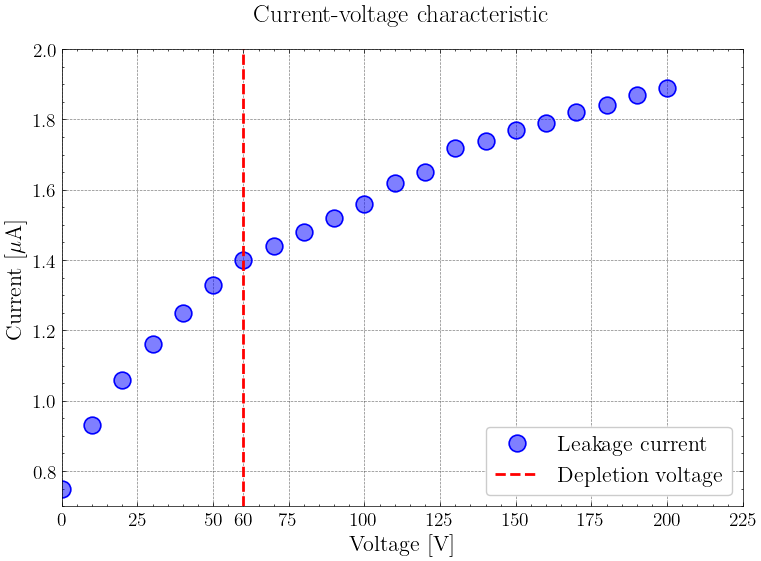

In [5]:
plt.figure()
plt.plot(voltage, current,
         marker='o',
         markerfacecolor=(0,0,1,0.5),
         markeredgecolor=(0,0,1,1.0),
         markeredgewidth=1.2,
         lw=1,
         ls='none',
         markersize=12,
         label='Leakage current')

plt.axvline(60, color='r', lw=2, ls='--',
            label='Depletion voltage')

plt.title('Current-voltage characteristic', pad=20)
plt.xlabel('Voltage [V]')
plt.ylabel('Current [$\\mu$A]')
plt.xlim(0, )
plt.ylim(0.7, 2)
plt.xticks(list(plt.xticks()[0]) + [60])
plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
plt.legend(loc='lower right')
plt.tight_layout()
if save==1: plt.savefig(path+'CurrVoltChar'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()

### Pedestal Noise

In [6]:
file = open('Pedestal.txt', 'r')

adc = np.loadtxt(file, delimiter=';')

file.close()

In [7]:
pedestal = np.zeros(128)
shift = np.zeros(1000)
noise = np.zeros(128)

for i in range(128):
    pedestal[i] = np.mean(adc[i, :])
    
for i in range(1000):
    shift[i] = np.mean(adc[:, i] - pedestal[:])
    
for i in range(128):
    noise[i] = np.sqrt( (1/999)*np.sum((adc[i, :] - pedestal[i] - shift[:])**2) )
    

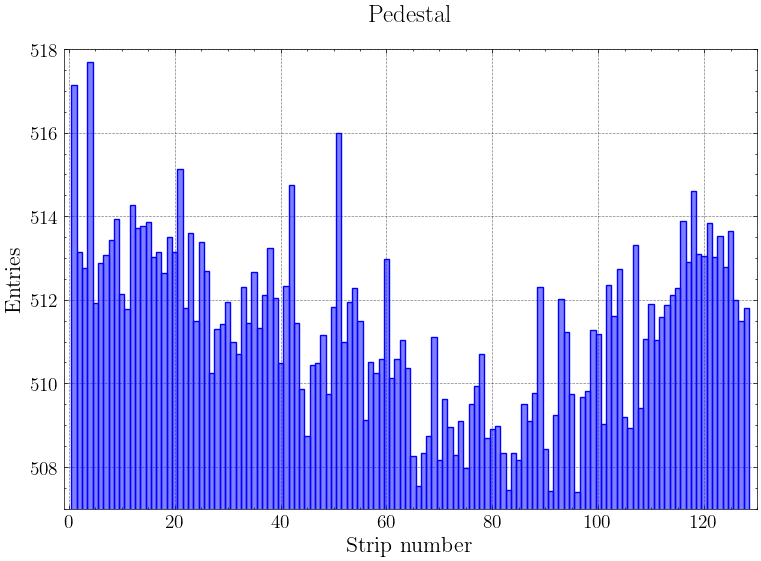

In [8]:
xbins = np.arange(1, 129)

plt.figure()
plt.bar(xbins, pedestal,
        width=1,
        facecolor=(0,0,1,0.5),
        edgecolor=(0,0,1,1.0),
        lw=1,
        ls='solid') #,
        #label='LABEL')
         
plt.title('Pedestal',pad=20)
plt.xlabel('Strip number')
plt.ylabel('Entries')
plt.xlim(-1, 130)
plt.ylim(507, 518)
plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
#plt.legend(loc='best')
plt.tight_layout()
if save==1: plt.savefig(path+'pedestal'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()

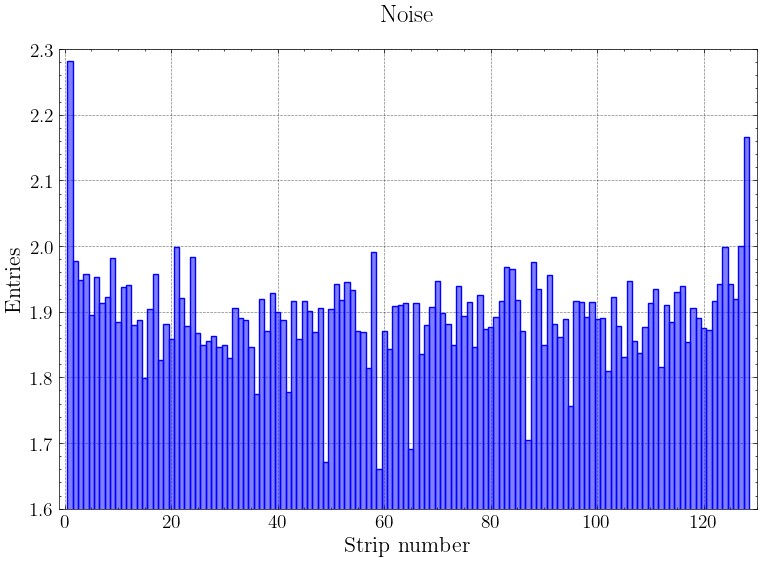

In [9]:
plt.figure()
plt.bar(xbins, noise,
        width=1,
        facecolor=(0,0,1,0.5),
        edgecolor=(0,0,1,1.0),
        lw=1,
        ls='solid') #,
        #label='LABEL')
         
plt.title('Noise',pad=20)
plt.xlabel('Strip number')
plt.ylabel('Entries')
plt.xlim(-1, 130)
plt.ylim(1.6, 2.3)
plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
#plt.legend(loc='best')
plt.tight_layout()
if save==1: plt.savefig(path+'noise'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()

In [10]:
hist, bin_edges = np.histogram(shift, bins=20, density=True)

In [11]:
def gaussian(x, amp, mu, sigma):
    """Gaussian function for fitting"""
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

In [12]:
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
xgauss = np.linspace(-10, 10, 1000)

# Fit Gaussian to the distribution
params, cov = curve_fit(gaussian, bin_centers, hist)
amp, mu, sigma = params
fit_curve = gaussian(xgauss, amp, mu, sigma)

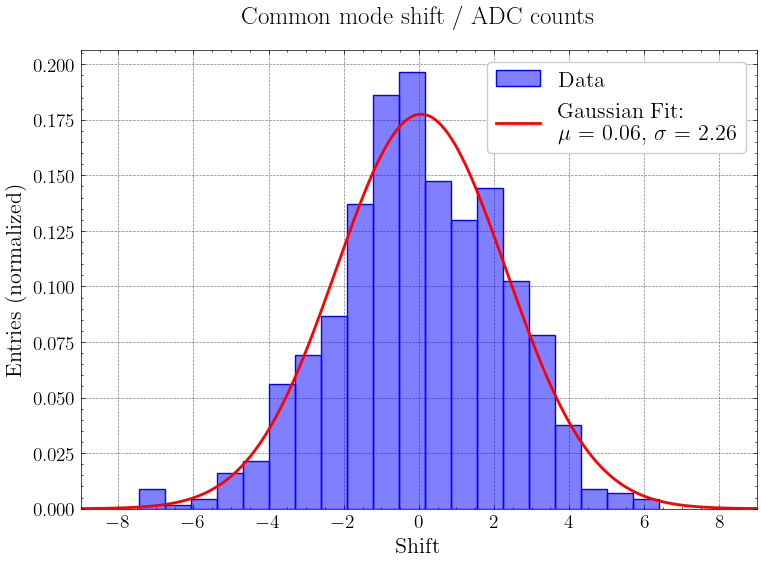

In [13]:
plt.figure()

plt.hist(shift,
         bins=20,
         density=True,
         histtype='barstacked',
         facecolor=(0,0,1,0.5),
         edgecolor=(0,0,1,1.0),
         lw=1,
         ls='solid',
         label='Data')
         
plt.plot(xgauss, fit_curve, 'r-', linewidth=2,
         label=f'Gaussian Fit:\n $\\mu$ = {mu:.2f}, $\\sigma$ = {sigma:.2f}')
         
plt.title('Common mode shift / ADC counts', pad=20)
plt.xlabel('Shift')
plt.ylabel('Entries (normalized)')
plt.xlim(-9, 9)
plt.ylim(0, )
plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
plt.legend(loc='best')
plt.tight_layout()
if save==1: plt.savefig(path+'shift'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()

### Calibration measurements

#### Delay measurement

In [14]:
file = open('Calib/delay_optimum_measure.txt', 'r')

next(file)
next(file)
line = file.readline()

time = []
adc_counts = []

while line:
    time.append(line.split()[0])
    adc_counts.append(line.split()[1])
    
    line = file.readline()

file.close()

In [15]:
# Replace commas with periods and convert to float
time_float = np.array([float(t.replace(',', '.')) for t in time])
adc_counts_float = np.array([float(t.replace(',', '.')) for t in adc_counts])

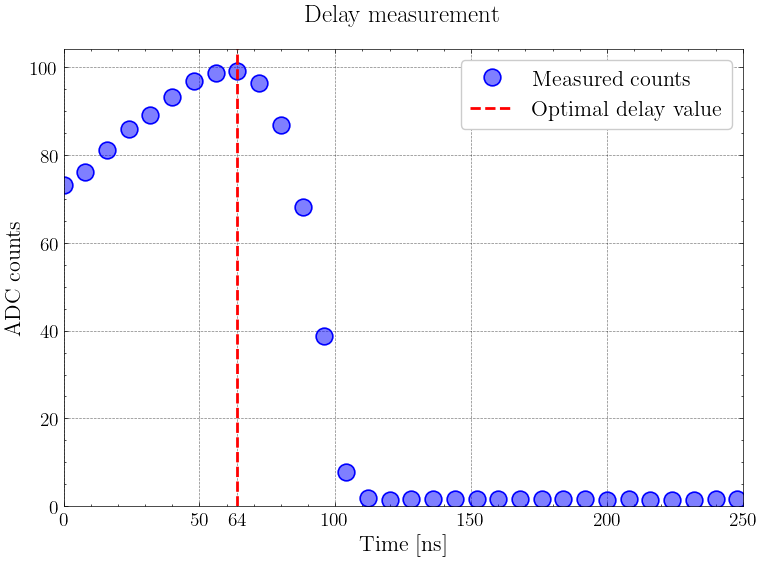

In [16]:
plt.figure()
plt.plot(time_float, adc_counts_float,
         marker='o',
         markerfacecolor=(0,0,1,0.5),
         markeredgecolor=(0,0,1,1.0),
         markeredgewidth=1.2,
         lw=1,
         ls='none',
         markersize=12,
         label='Measured counts')

plt.axvline(64, color='r', lw=2, ls='--',
            label='Optimal delay value')

plt.title('Delay measurement', pad=20)
plt.xlabel('Time [ns]')
plt.ylabel('ADC counts')
plt.xlim(0, 250)
plt.ylim(0, )
plt.xticks(list(plt.xticks()[0]) + [64])
plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
plt.legend(loc='best')
plt.tight_layout()
if save==1: plt.savefig(path+'optDelay'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()

#### Channel measurement

In [17]:
def data_read(name):
    """
    Reads the calibration data from a file and returns the calibration values
    """
    
    file = open(name+'.txt', 'r')

    next(file)
    next(file)
    line = file.readline()

    charge = []
    adc = []

    while line:
        charge.append(line.split()[0])
        adc.append(line.split()[1])
        line = file.readline()

    file.close()

    # Replace commas with periods and convert to float
    charge_float = np.array([float(t.replace(',', '.')) for t in charge])
    adc_float = np.array([float(t.replace(',', '.')) for t in adc])
    
    return charge_float, adc_float

In [18]:
def plot_channel(cha, adc, color, linest, cha_name):
    
    plt.plot(cha, adc,
             marker='o',
             markerfacecolor=(color,0.5),
             markeredgecolor=(color,0.8),
             markeredgewidth=1,
             lw=2,
             ls=linest,
             color=color,
             markersize=6,
             label=cha_name)
    
    return

In [19]:
cha20, adc20 = data_read('Calib/ch20_plot')
cha40, adc40 = data_read('Calib/ch40_plot')
cha60, adc60 = data_read('Calib/ch60_plot')
cha80, adc80 = data_read('Calib/ch80_plot')
cha80_0V, adc80_0V = data_read('Calib/ch80_0_VOLT_plot')
cha100, adc100 = data_read('Calib/ch100_plot')

average = (adc20 + adc40 + adc60 + adc80 + adc100) / 5

color = [[1,0,0], [0,1,0], [0,0,1], [1,0,1], [0,1,1]]

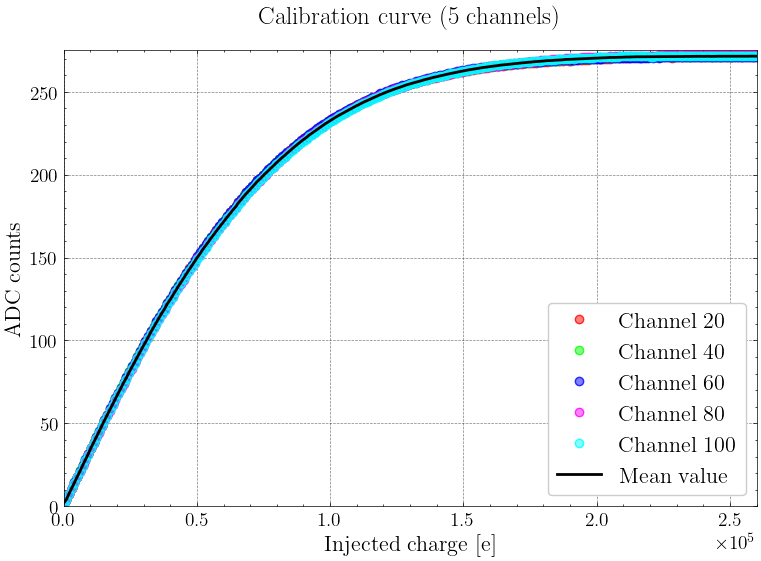

In [20]:
plt.figure()

plot_channel(cha20, adc20, color[0], 'none', 'Channel 20')
plot_channel(cha40, adc40, color[1], 'none', 'Channel 40')
plot_channel(cha60, adc60, color[2], 'none', 'Channel 60')
plot_channel(cha80, adc80, color[3], 'none', 'Channel 80')
plot_channel(cha100, adc100, color[4], 'none', 'Channel 100')

plt.plot(cha20, average,
         color='black',
         lw=2,
         ls='-',
         label='Mean value')

plt.title('Calibration curve (5 channels)', pad=20)
plt.xlabel('Injected charge [e]')
plt.ylabel('ADC counts')
plt.xlim(0, 260100)
plt.ylim(0, 275)
plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
plt.legend(loc='lower right')
plt.tight_layout()
if save==1: plt.savefig(path+'calibMeas'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()

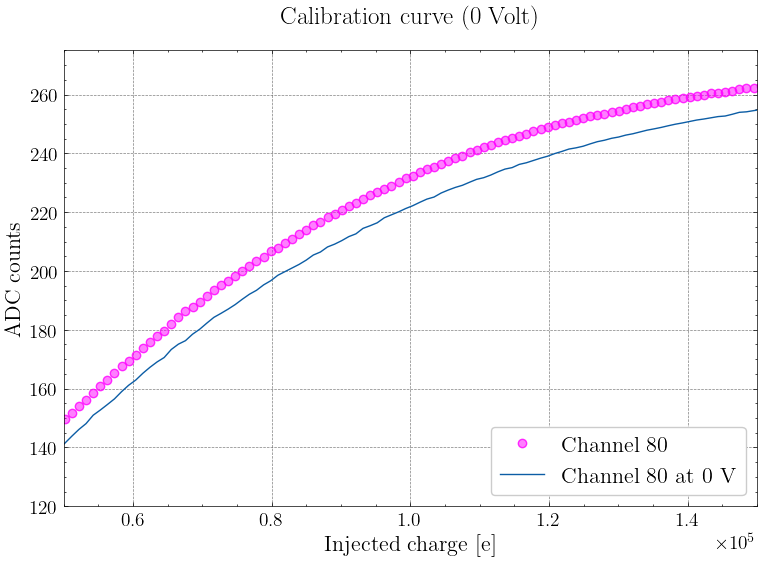

In [21]:
plt.figure()

plot_channel(cha80, adc80, color[3], 'none', 'Channel 80')

plt.plot(cha80_0V, adc80_0V,
         lw=1,
         ls='-',
         label='Channel 80 at 0 V')

plt.title('Calibration curve (0 Volt)', pad=20)
plt.xlabel('Injected charge [e]')
plt.ylabel('ADC counts')
plt.xlim(50000, 150000)
plt.ylim(120, 275)
plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
plt.legend(loc='lower right')
plt.tight_layout()
if save==1: plt.savefig(path+'calib0Volt'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()

#### Polynomial fit

In [22]:
def polyfun(x, a, b, c, d, e):
    """4-th degree polynomial fitting"""
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

In [23]:
xspace = np.linspace(0, 300, 1000)

params, cov = curve_fit(polyfun, average[0:120], cha20[0:120])
a, b, c, d, e = params
fit_curve = polyfun(xspace, a, b, c, d, e)

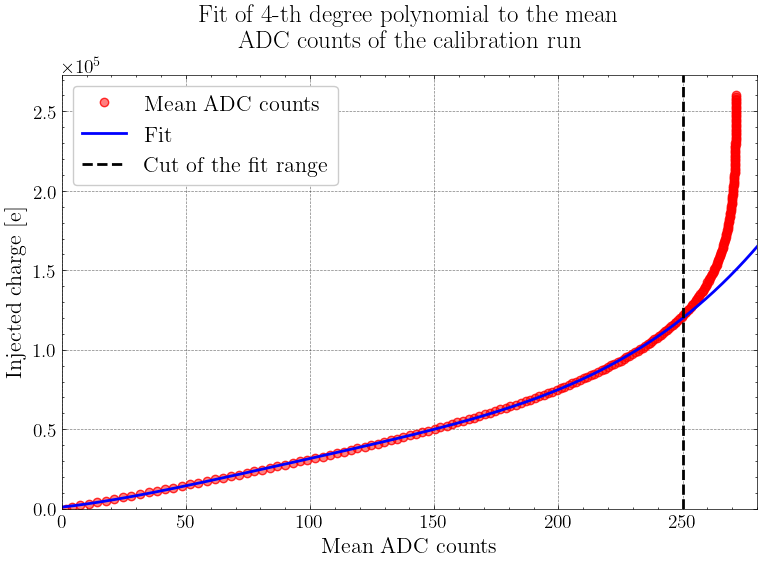

In [24]:
plt.figure()

plot_channel(average, cha20, color[0], 'none', 'Mean ADC counts')

plt.plot(xspace, fit_curve,
         color='blue',
         lw=2,
         ls='-',
         label='Fit')

plt.axvline(250, color='k', lw=2, ls='--',
            label='Cut of the fit range')

plt.title('Fit of 4-th degree polynomial to the mean'
          '\n'
          'ADC counts of the calibration run', pad=20)
plt.xlabel('Mean ADC counts')
plt.ylabel('Injected charge [e]')
plt.xlim(0, 280)
plt.ylim(0, )
plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
plt.legend(loc='best')
plt.tight_layout()
if save==1: plt.savefig(path+'polyFit'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()

In [25]:
# Print the parameters of the polynomial fit
# using scientific notation {a:e} as example
print(f'a = {a:e}')
print(f'b = {b:e}')
print(f'c = {c:e}')
print(f'd = {d:e}')
print(f'e = {e:e}')

a = 5.263758e-05
b = -1.913336e-02
c = 2.693738e+00
d = 1.753607e+02
e = 9.804066e+02


### Measuring the strip sensor by using the laser

In [26]:
delay, adc_laser = data_read('Laserscan/laser_opt_plot')

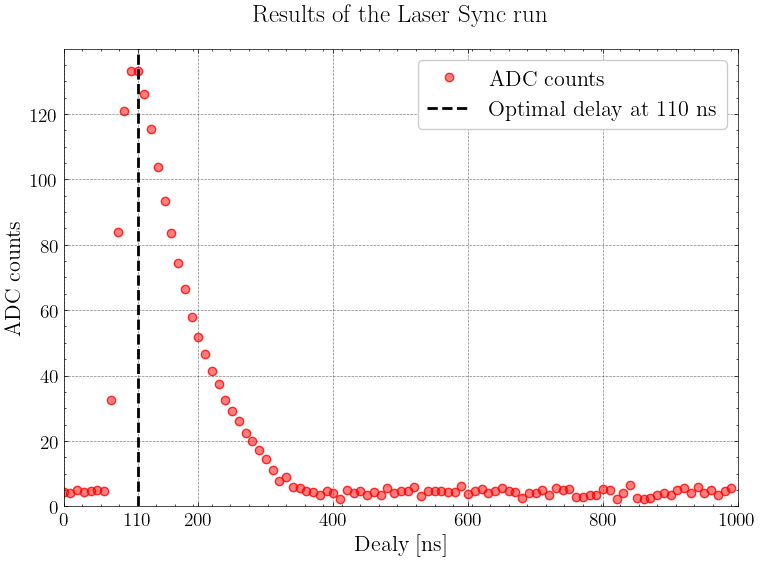

In [27]:
plt.figure()

plot_channel(delay, adc_laser, color[0], 'none', 'ADC counts')

plt.axvline(110, color='k', lw=2, ls='--',
            label='Optimal delay at 110 ns')

plt.title('Results of the Laser Sync run', pad=20)
plt.xlabel('Dealy [ns]')
plt.ylabel('ADC counts')
plt.xlim(0, 1000)
plt.ylim(0, )
plt.xticks(list(plt.xticks()[0]) + [110])
plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
plt.legend(loc='best')
plt.tight_layout()
if save==1: plt.savefig(path+'laserSync'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()

In [28]:
lascan = np.loadtxt('Laserscan.txt',unpack=True)

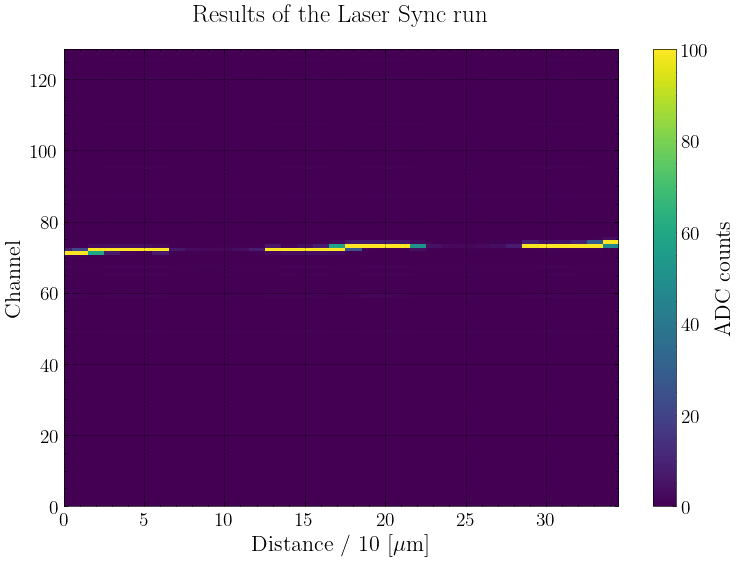

In [29]:
plt.figure()

plt.imshow(lascan, vmin=0, vmax=100, cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(label='ADC counts')

plt.title('Results of the Laser Sync run', pad=20)
plt.xlabel('Distance / 10 [$\\mu$m]')
plt.ylabel('Channel')
plt.xlim(0, )
plt.ylim(0, )

plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
#plt.legend(loc='best')
plt.tight_layout()
if save==1: plt.savefig(path+'bigHeatmap'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()

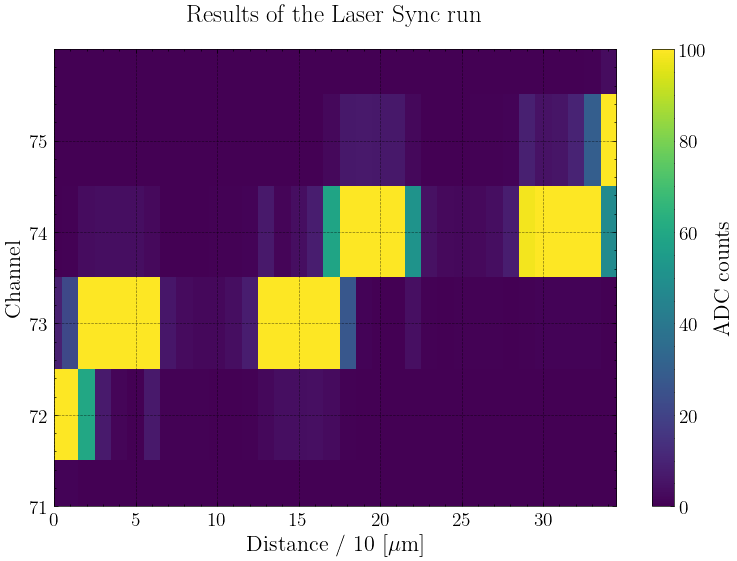

In [30]:
plt.figure()

plt.imshow(lascan, vmin=0, vmax=100, cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(label='ADC counts')

plt.title('Results of the Laser Sync run', pad=20)
plt.xlabel('Distance / 10 [$\\mu$m]')
plt.ylabel('Channel')
plt.xlim(0, )
plt.ylim(70, 75)
plt.yticks(np.arange(70, 75, 1), labels=np.arange(71, 76, 1))
#plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
#plt.legend(loc='best')
plt.tight_layout()
if save==1: plt.savefig(path+'smallHeatmap'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()

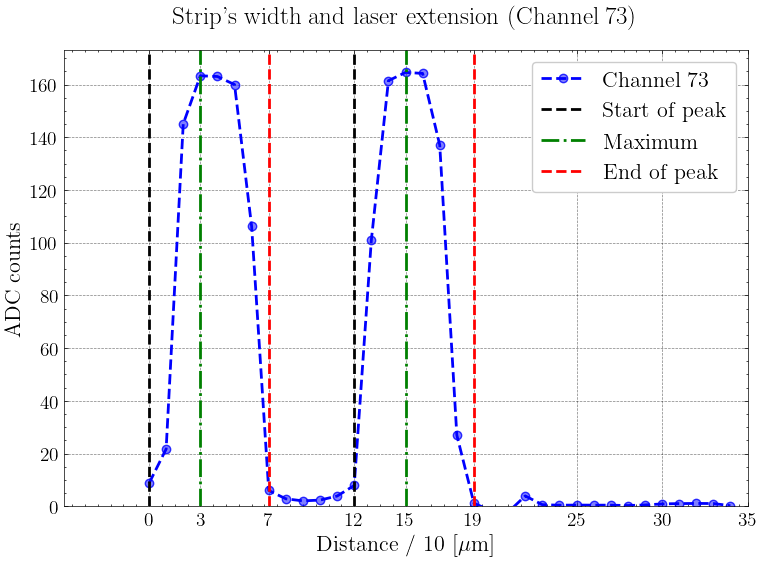

In [31]:
plt.figure()

plot_channel(np.linspace(0, 34, 35), lascan[72, :],
             color[2], '--', 'Channel 73')

plt.axvline(0, color='k', lw=2, ls='--',
            label='Start of peak')
plt.axvline(3, color='g', lw=2, ls='-.',
            label='Maximum')
plt.axvline(7, color='r', lw=2, ls='--',
            label='End of peak')

plt.axvline(12, color='k', lw=2, ls='--')
plt.axvline(15, color='g', lw=2, ls='-.')
plt.axvline(19, color='r', lw=2, ls='--')

plt.title('Strip\'s width and laser extension (Channel 73)', pad=20)
plt.xlabel('Distance / 10 [$\\mu$m]')
plt.ylabel('ADC counts')
plt.xlim(-5, 35)
plt.ylim(0, )
plt.xticks(list([0, 3, 7, 12, 15, 19, 25, 30, 35]))
plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
plt.legend(loc='best')
plt.tight_layout()
if save==1: plt.savefig(path+'width73'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()

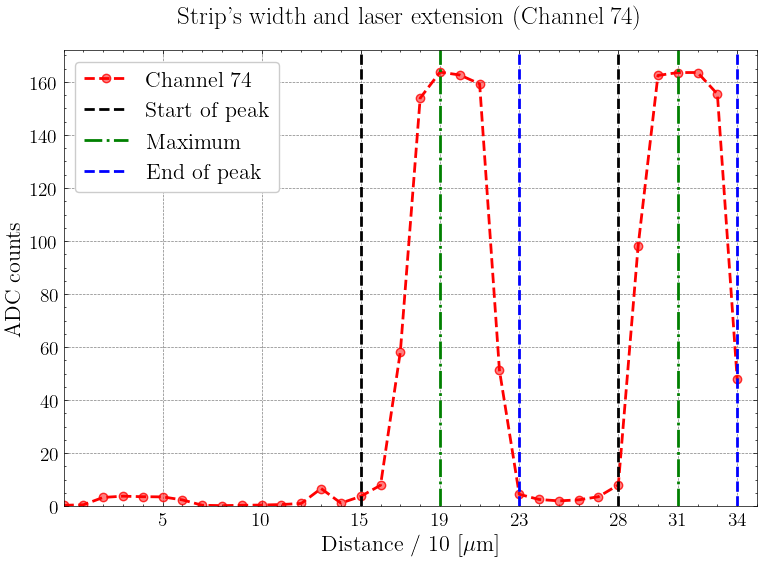

In [32]:
plt.figure()

plot_channel(np.linspace(0, 34, 35), lascan[73, :],
             color[0], '--', 'Channel 74')

plt.axvline(15, color='k', lw=2, ls='--',
            label='Start of peak')
plt.axvline(19, color='g', lw=2, ls='-.',
            label='Maximum')
plt.axvline(23, color='b', lw=2, ls='--',
            label='End of peak')

plt.axvline(28, color='k', lw=2, ls='--')
plt.axvline(31, color='g', lw=2, ls='-.')
plt.axvline(34, color='b', lw=2, ls='--')

plt.title('Strip\'s width and laser extension (Channel 74)', pad=20)
plt.xlabel('Distance / 10 [$\\mu$m]')
plt.ylabel('ADC counts')
plt.xlim(0, 35)
plt.ylim(0, )
plt.xticks(list([5, 10 , 15, 19, 23, 28, 31, 34]))
plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
plt.legend(loc='best')
plt.tight_layout()
if save==1: plt.savefig(path+'width74'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()

In [33]:
'''
import os

def combine_text_files(input_files, output_file, delimiter='\t'):
    """
    Combines multiple single-column text files into a multi-column text file.
    
    Args:
        input_files (list): List of paths to input text files
        output_file (str): Path for the output combined text file
        delimiter (str): Column separator for output file (default: tab)
    """
    # Read all input files
    columns = []
    for file_path in input_files:
        with open(file_path, 'r') as f:
            # Read all lines and strip whitespace
            column = [line.strip() for line in f.readlines()]
            columns.append(column)
    
    # Verify consistent row count
    row_counts = [len(col) for col in columns]
    if len(set(row_counts)) > 1:
        raise ValueError(f"Inconsistent row counts: {row_counts}. All files must have same number of rows.")
    
    # Transpose columns into rows
    combined_data = []
    for i in range(len(columns[0])):
        row = delimiter.join(col[i] for col in columns)
        combined_data.append(row)
    
    # Write output file
    with open(output_file, 'w') as f:
        f.write('\n'.join(combined_data))
'''

'\nimport os\n\ndef combine_text_files(input_files, output_file, delimiter=\'\t\'):\n    """\n    Combines multiple single-column text files into a multi-column text file.\n\n    Args:\n        input_files (list): List of paths to input text files\n        output_file (str): Path for the output combined text file\n        delimiter (str): Column separator for output file (default: tab)\n    """\n    # Read all input files\n    columns = []\n    for file_path in input_files:\n        with open(file_path, \'r\') as f:\n            # Read all lines and strip whitespace\n            column = [line.strip() for line in f.readlines()]\n            columns.append(column)\n\n    # Verify consistent row count\n    row_counts = [len(col) for col in columns]\n    if len(set(row_counts)) > 1:\n        raise ValueError(f"Inconsistent row counts: {row_counts}. All files must have same number of rows.")\n\n    # Transpose columns into rows\n    combined_data = []\n    for i in range(len(columns[0])):\

In [34]:
'''
combine_text_files(
    input_files=['CCEL/0CCEL.txt',
                 'CCEL/10CCEL.txt',
                 'CCEL/20CCEL.txt',
                 'CCEL/30CCEL.txt',
                 'CCEL/40CCEL.txt',
                 'CCEL/50CCEL.txt',
                 'CCEL/60CCEL.txt',
                 'CCEL/70CCEL.txt',
                 'CCEL/80CCEL.txt',
                 'CCEL/90CCEL.txt',
                 'CCEL/100CCEL.txt',
                 'CCEL/110CCEL.txt',
                 'CCEL/120CCEL.txt',
                 'CCEL/130CCEL.txt',
                 'CCEL/140CCEL.txt',
                 'CCEL/150CCEL.txt',
                 'CCEL/160CCEL.txt',
                 'CCEL/170CCEL.txt',
                 'CCEL/180CCEL.txt',
                 'CCEL/190CCEL.txt',
                 'CCEL/200CCEL.txt',
                 ],
    output_file='CCEL_combined.txt',
    delimiter='\t'
)
'''

"\ncombine_text_files(\n    input_files=['CCEL/0CCEL.txt',\n                 'CCEL/10CCEL.txt',\n                 'CCEL/20CCEL.txt',\n                 'CCEL/30CCEL.txt',\n                 'CCEL/40CCEL.txt',\n                 'CCEL/50CCEL.txt',\n                 'CCEL/60CCEL.txt',\n                 'CCEL/70CCEL.txt',\n                 'CCEL/80CCEL.txt',\n                 'CCEL/90CCEL.txt',\n                 'CCEL/100CCEL.txt',\n                 'CCEL/110CCEL.txt',\n                 'CCEL/120CCEL.txt',\n                 'CCEL/130CCEL.txt',\n                 'CCEL/140CCEL.txt',\n                 'CCEL/150CCEL.txt',\n                 'CCEL/160CCEL.txt',\n                 'CCEL/170CCEL.txt',\n                 'CCEL/180CCEL.txt',\n                 'CCEL/190CCEL.txt',\n                 'CCEL/200CCEL.txt',\n                 ],\n    output_file='CCEL_combined.txt',\n    delimiter='\t'\n)\n"

### Charge collection efficiency

#### CCE Laser

In [35]:
ccel = np.loadtxt('CCEL_combined.txt',unpack=False)

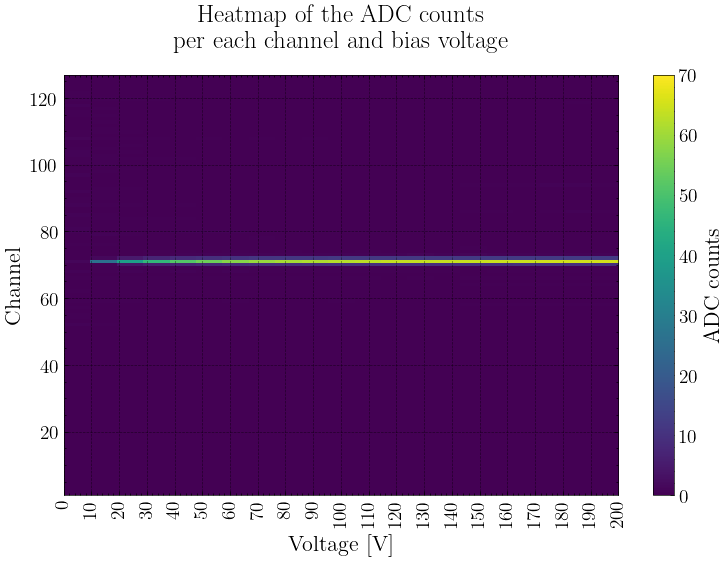

In [36]:
plt.figure()

plt.imshow(ccel, vmin=0, vmax=70, cmap='viridis', origin='lower', extent=[0 , 200, 0, 127], aspect='auto')
plt.colorbar(label='ADC counts')

plt.title('Heatmap of the ADC counts'
          '\n'
          'per each channel and bias voltage', pad=20)
plt.xlabel('Voltage [V]')
plt.ylabel('Channel')
plt.xlim(0, )
plt.ylim(1, )
plt.xticks(np.arange(0, 201, 10))
plt.xticks(rotation=90)
plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
#plt.legend(loc='best')
plt.tight_layout()
if save==1: plt.savefig(path+'bigVoltage'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()

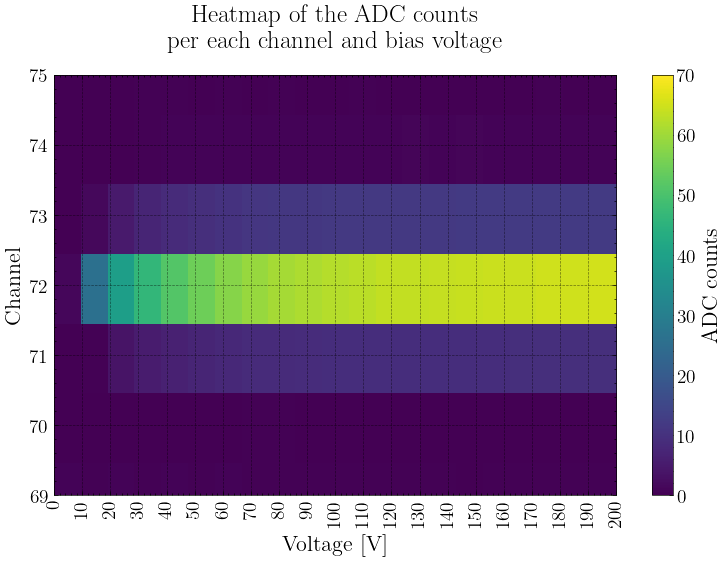

In [37]:
plt.figure()

plt.imshow(ccel, vmin=0, vmax=70, cmap='viridis', origin='lower', extent=[0 , 200, 0, 127], aspect='auto')
plt.colorbar(label='ADC counts')

plt.title('Heatmap of the ADC counts'
          '\n'
          'per each channel and bias voltage', pad=20)
plt.xlabel('Voltage [V]')
plt.ylabel('Channel')
plt.xlim(0, )
plt.ylim(68, 74)
plt.xticks(np.arange(0, 201, 10))
plt.yticks(np.arange(68, 75, 1), labels=np.arange(69, 76, 1))
plt.xticks(rotation=90)
#plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
#plt.legend(loc='best')
plt.tight_layout()
if save==1: plt.savefig(path+'smallVoltage'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()

In [38]:
def deepFun(x, a):
    D = 300
    U_dep = 80
    return (1 - np.exp(-(D * np.sqrt(x/U_dep))/a)) / (1 - np.exp(-D/a))

In [39]:
xspace = np.linspace(0, 80, 1000)

data = ccel[71, :]/ccel[71, 8]

params, cov = curve_fit(deepFun, np.linspace(0, 80, 9), data[:9], bounds=(0, 300))
a_opt = params[0]
fit_curve = deepFun(xspace, a_opt)
a_err = np.sqrt(cov[0, 0])

print(f"Optimal a parameter: {a_opt:.6f}")
print(f"Uncertainty in a: ± {a_err:.6f}")
print(f"Relative uncertainty: ± {100*a_err/a_opt:.4f}%")

Optimal a parameter: 252.717907
Uncertainty in a: ± 30.108226
Relative uncertainty: ± 11.9138%


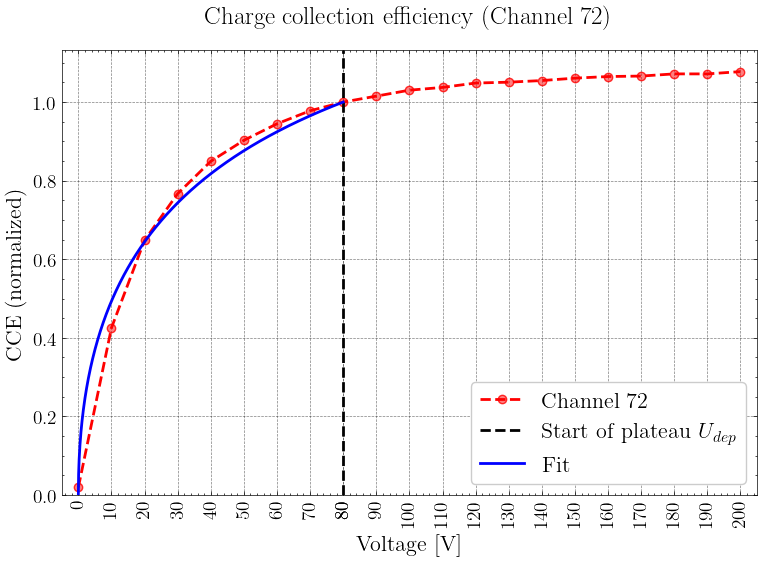

In [40]:
plt.figure()

plot_channel(np.linspace(0, 200, 21), data,
             color[0], '--', 'Channel 72')

plt.axvline(80, color='k', lw=2, ls='--',
            label='Start of plateau $U_{dep}$')

plt.plot(xspace, fit_curve,
         color='blue',
         lw=2,
         ls='-',
         label='Fit')

plt.title('Charge collection efficiency (Channel 72)', pad=20)
plt.xlabel('Voltage [V]')
plt.ylabel('CCE (normalized)')
plt.xlim(-5, 205)
plt.ylim(0, )
plt.xticks(np.arange(0, 201, 10))
plt.xticks(rotation=90)
plt.xticks(list(plt.xticks()[0]) + [80])
plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
plt.legend(loc='best')
plt.tight_layout()
if save==1: plt.savefig(path+'channel72'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()

#### CCE Beta source

In [41]:
'''
import os

def source_avg(input_files, output_file):
    """
    Compute first column averages for multiple files and save to single output file
    
    Args:
        input_files (list): List of input file paths
        output_file (str): Path for output text file
    """
    averages = []
    
    for file_path in input_files:
        values = []
        
        with open(file_path, 'r') as f:
            for line in f:
                # Skip empty lines and lines starting with #
                if not line.strip() or line.startswith('#'):
                    continue
                
                # Split line into columns
                columns = line.split()
                
                # Process only if there's at least one column
                if columns:
                    try:
                        # Extract first column value and convert to float
                        value = float(columns[0])
                        values.append(value)
                    except ValueError:
                        # Skip lines with non-numeric values in first column
                        continue
        
        # Calculate average if we have valid values
        if values:
            avg = sum(values) / len(values)
            averages.append(avg)
        else:
            # Use 0 if no valid values found
            averages.append(0.0)
    
    # Write all averages to output file
    with open(output_file, 'w') as f:
        for avg in averages:
            f.write(f"{avg}\n")
    
    print(f"Saved {len(averages)} averages to {output_file}")
'''

'\nimport os\n\ndef source_avg(input_files, output_file):\n    """\n    Compute first column averages for multiple files and save to single output file\n\n    Args:\n        input_files (list): List of input file paths\n        output_file (str): Path for output text file\n    """\n    averages = []\n\n    for file_path in input_files:\n        values = []\n\n        with open(file_path, \'r\') as f:\n            for line in f:\n                # Skip empty lines and lines starting with #\n                if not line.strip() or line.startswith(\'#\'):\n                    continue\n\n                # Split line into columns\n                columns = line.split()\n\n                # Process only if there\'s at least one column\n                if columns:\n                    try:\n                        # Extract first column value and convert to float\n                        value = float(columns[0])\n                        values.append(value)\n                    except ValueE

In [42]:
'''
source_avg(
    input_files=['source_measurement/0_Cluster_adc_entries.txt',
                 'source_measurement/10_Cluster_adc_entries.txt',
                 'source_measurement/20_Cluster_adc_entries.txt',
                 'source_measurement/30_Cluster_adc_entries.txt',
                 'source_measurement/40_Cluster_adc_entries.txt',
                 'source_measurement/50_Cluster_adc_entries.txt',
                 'source_measurement/60_Cluster_adc_entries.txt',
                 'source_measurement/70_Cluster_adc_entries.txt',
                 'source_measurement/80_Cluster_adc_entries.txt',
                 'source_measurement/90_Cluster_adc_entries.txt',
                 'source_measurement/100_Cluster_adc_entries.txt',
                 'source_measurement/110_Cluster_adc_entries.txt',
                 'source_measurement/120_Cluster_adc_entries.txt',
                 'source_measurement/130_Cluster_adc_entries.txt',
                 'source_measurement/140_Cluster_adc_entries.txt',
                 'source_measurement/150_Cluster_adc_entries.txt',
                 'source_measurement/160_Cluster_adc_entries.txt',
                 'source_measurement/170_Cluster_adc_entries.txt',
                 'source_measurement/180_Cluster_adc_entries.txt',
                 'source_measurement/190_Cluster_adc_entries.txt',
                 'source_measurement/200_Cluster_adc_entries.txt',
                 ],
    output_file='SOURCE_combined.txt'
)
'''

"\nsource_avg(\n    input_files=['source_measurement/0_Cluster_adc_entries.txt',\n                 'source_measurement/10_Cluster_adc_entries.txt',\n                 'source_measurement/20_Cluster_adc_entries.txt',\n                 'source_measurement/30_Cluster_adc_entries.txt',\n                 'source_measurement/40_Cluster_adc_entries.txt',\n                 'source_measurement/50_Cluster_adc_entries.txt',\n                 'source_measurement/60_Cluster_adc_entries.txt',\n                 'source_measurement/70_Cluster_adc_entries.txt',\n                 'source_measurement/80_Cluster_adc_entries.txt',\n                 'source_measurement/90_Cluster_adc_entries.txt',\n                 'source_measurement/100_Cluster_adc_entries.txt',\n                 'source_measurement/110_Cluster_adc_entries.txt',\n                 'source_measurement/120_Cluster_adc_entries.txt',\n                 'source_measurement/130_Cluster_adc_entries.txt',\n                 'source_measurement/140_Cl

In [43]:
file = open('SOURCE_combined.txt', 'r')

line = file.readline()

src = []

while line:
    src.append(line.split()[0])
    
    line = file.readline()

file.close()

src_float = np.array([float(t.replace(',', '.')) for t in src])

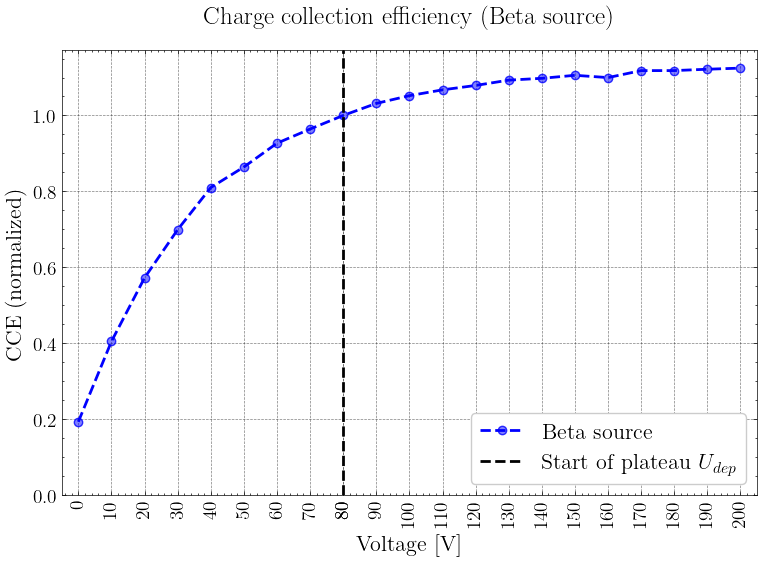

In [44]:
plt.figure()

plot_channel(np.linspace(0, 200, 21), src_float/src_float[8],
             color[2], '--', 'Beta source')

plt.axvline(80, color='k', lw=2, ls='--',
            label='Start of plateau $U_{dep}$')

plt.title('Charge collection efficiency (Beta source)', pad=20)
plt.xlabel('Voltage [V]')
plt.ylabel('CCE (normalized)')
plt.xlim(-5, 205)
plt.ylim(0, )
plt.xticks(np.arange(0, 201, 10))
plt.xticks(rotation=90)
plt.xticks(list(plt.xticks()[0]) + [80])
plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
plt.legend(loc='best')
plt.tight_layout()
if save==1: plt.savefig(path+'betaSource'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()

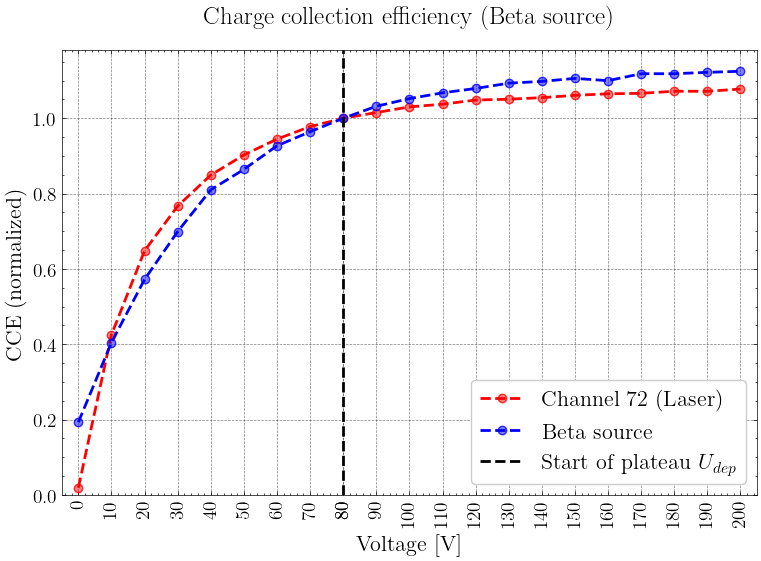

In [45]:
plt.figure()

plot_channel(np.linspace(0, 200, 21), data,
             color[0], '--', 'Channel 72 (Laser)')

plot_channel(np.linspace(0, 200, 21), src_float/src_float[8],
             color[2], '--', 'Beta source')

plt.axvline(80, color='k', lw=2, ls='--',
            label='Start of plateau $U_{dep}$')

plt.title('Charge collection efficiency (Beta source)', pad=20)
plt.xlabel('Voltage [V]')
plt.ylabel('CCE (normalized)')
plt.xlim(-5, 205)
plt.ylim(0, )
plt.xticks(np.arange(0, 201, 10))
plt.xticks(rotation=90)
plt.xticks(list(plt.xticks()[0]) + [80])
plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
plt.legend(loc='best')
plt.tight_layout()
if save==1: plt.savefig(path+'betaLaserSource'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()

### Large source scan

In [46]:
cluster = np.array([43777, 875137, 75273, 2357, 58, 0, 0])
bins = np.arange(len(cluster))

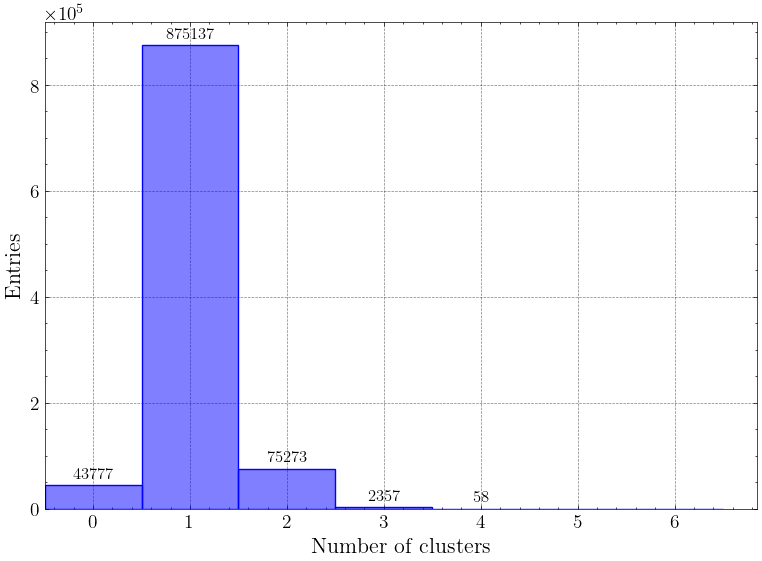

In [47]:
plt.figure()

plt.bar(bins, cluster, #color='blue', edgecolor='black')
        width=1,
        facecolor=(0,0,1,0.5),
        edgecolor=(0,0,1,1.0),
        lw=1,
        ls='solid') #,
        #label='LABEL')
        
for i in range(len(cluster)):
    if cluster[i] > 0:
        plt.annotate(f'{cluster[i]:.0f}', 
                     (bins[i], cluster[i]),  # Anchor point (top of bar)
                     xytext=(0, 3),             # 3-point vertical offset
                     textcoords='offset points', # Offset in points
                     ha='center',               # Horizontal alignment
                     va='bottom',               # Vertical alignment
                     rotation=0, 
                     fontsize=12)
         
#plt.title('Number of clusters', pad=20)
plt.xlabel('Number of clusters')
plt.ylabel('Entries')
plt.xlim(-0.5, )
#plt.ylim(0, )
plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
#plt.legend(loc='best')
plt.tight_layout()
if save==1: plt.savefig(path+'cluster'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()

In [48]:
cluchan = np.array([0,
                    562927,
                    406888,
                    47034,
                    10298,
                    3375,
                    1364,
                    566,
                    262,
                    137,
                    77,
                    30,
                    12,
                    7,
                    5,
                    3,
                    1,
                    0,
                    0])
clubins = np.arange(len(cluchan))

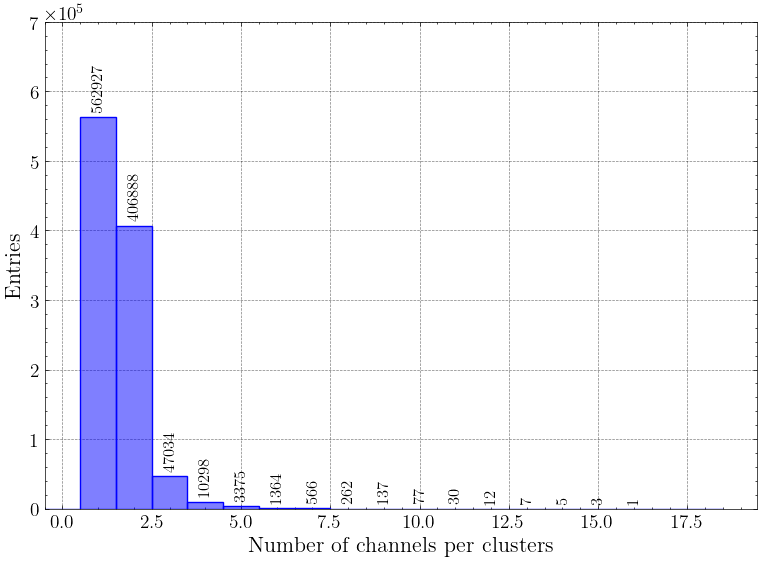

In [49]:
plt.figure()

plt.bar(clubins, cluchan, #color='blue', edgecolor='black')
        width=1,
        facecolor=(0,0,1,0.5),
        edgecolor=(0,0,1,1.0),
        lw=1,
        ls='solid') #,
        #label='LABEL')
        
for i in range(len(cluchan)):
    if cluchan[i] > 0:
        plt.annotate(f'{cluchan[i]:.0f}', 
                     (clubins[i], cluchan[i]),  # Anchor point (top of bar)
                     xytext=(0, 3),             # 3-point vertical offset
                     textcoords='offset points', # Offset in points
                     ha='center',               # Horizontal alignment
                     va='bottom',               # Vertical alignment
                     rotation=90, 
                     fontsize=12)
         
#plt.title('Number of clusters', pad=20)
plt.xlabel('Number of channels per clusters')
plt.ylabel('Entries')
plt.xlim(-0.5, )
plt.ylim(0, 700000)
plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
#plt.legend(loc='best')
plt.tight_layout()
if save==1: plt.savefig(path+'cluchans'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()

In [50]:
file = open('source_measurement/hitmap.txt', 'r')

next(file)
line = file.readline()

hit = []

while line:
    hit.append(line.split()[0])
    
    line = file.readline()

file.close()

hit_float = np.array([float(t.replace(',', '.')) for t in hit])

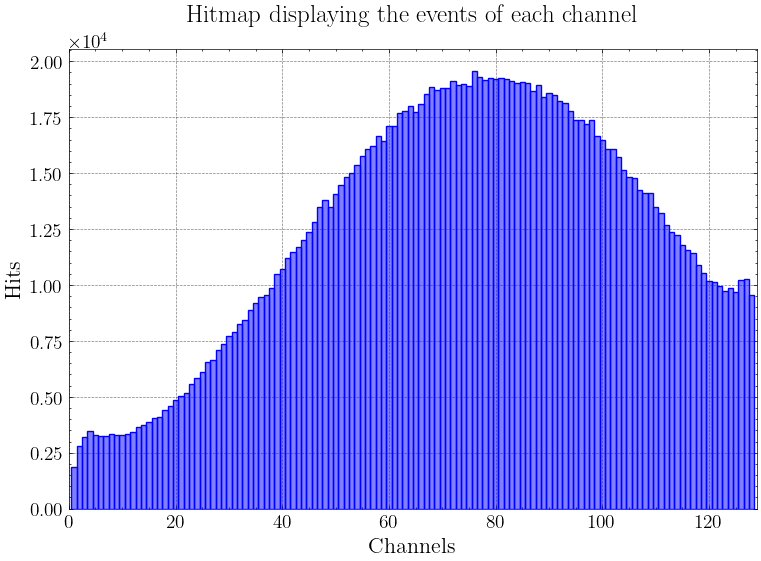

In [51]:
plt.figure()

plt.bar(xbins, hit_float, #color='blue', edgecolor='black')
        width=1,
        facecolor=(0,0,1,0.5),
        edgecolor=(0,0,1,1.0),
        lw=1,
        ls='solid') #,
        #label='LABEL')
         
plt.title('Hitmap displaying the events of each channel', pad=20)
plt.xlabel('Channels')
plt.ylabel('Hits')
plt.xlim(0, 129)
plt.ylim(0, )
plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
#plt.legend(loc='best')
plt.tight_layout()
if save==1: plt.savefig(path+'hitmap'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()

In [52]:
file = open('source_measurement/Cluster_adc_entries.txt', 'r')

next(file)
line = file.readline()

pulse = []

while line:
    pulse.append(line.split()[0])
    
    line = file.readline()

file.close()

pulse_float = np.array([float(t.replace(',', '.')) for t in pulse])
pulse_energy = pulse_float / 3.6  # Convert to keV

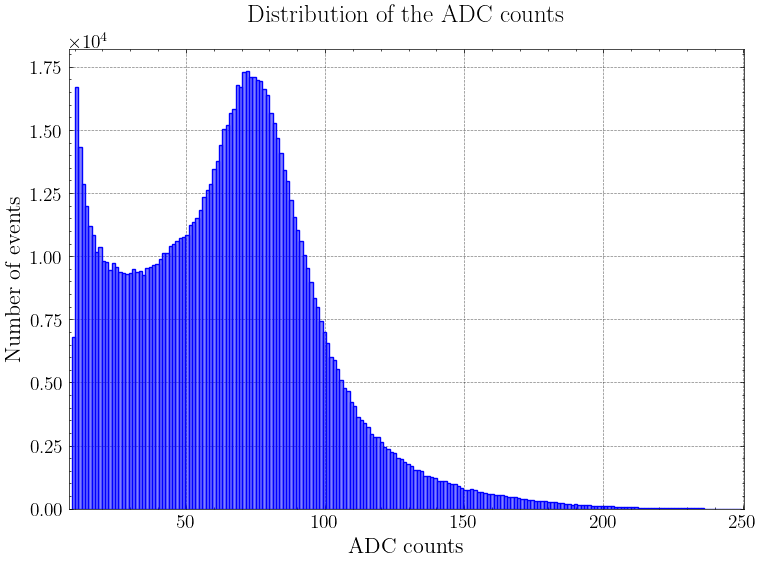

In [53]:
plt.figure()

h = plt.hist(pulse_float,
             bins=200,
             density=False,
             histtype='barstacked',
             facecolor=(0,0,1,0.5),
             edgecolor=(0,0,1,1.0),
             lw=1,
             ls='solid')#,
             #label='Data')
         
plt.title('Distribution of the ADC counts', pad=20)
plt.xlabel('ADC counts')
plt.ylabel('Number of events')
plt.xlim(min(h[1])-1, max(h[1])+1)
plt.ylim(0, )
plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
#plt.legend(loc='best')
plt.tight_layout()
if save==1: plt.savefig(path+'ADCdistrib'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()

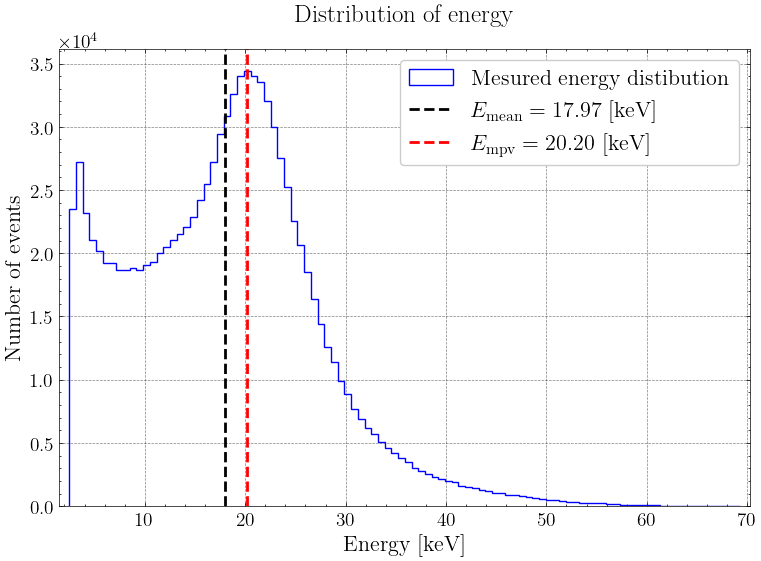

In [54]:
e_mean = np.mean(pulse_energy)

plt.figure()

h = plt.hist(pulse_energy,
             bins=100,
             density=False,
             histtype='step',
             facecolor=(0,0,1,0.5),
             edgecolor=(0,0,1,1.0),
             lw=1,
             ls='solid',
             label='Mesured energy distibution')

# Find the index of the maximum bin count
mpv_idx = np.argmax(h[0])
# Calculate the MPV as the center of the corresponding bin
e_mpv = 0.5 * (h[1][mpv_idx] + h[1][mpv_idx + 1])

plt.axvline(e_mean, color='k', lw=2, ls='--',
            label=r'$E_{\mathrm{mean}}'+f'= {e_mean:.2f}$ [keV]')

plt.axvline(e_mpv, color='r', lw=2, ls='--',
            label=r'$E_{\mathrm{mpv}}'+f'= {e_mpv:.2f}$ [keV]')
         
plt.title('Distribution of energy', pad=20)
plt.xlabel('Energy [keV]')
plt.ylabel('Number of events')
plt.xlim(min(h[1])-1, max(h[1])+1)
plt.ylim(0, )
plt.ticklabel_format(style='sci', axis='both', scilimits=[-4,4])
plt.legend(loc='best')
plt.tight_layout()
if save==1: plt.savefig(path+'ENERGYdistrib'+format,
                        dpi=image_save_dpi, bbox_inches='tight')
plt.show()